In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [52]:
# Load the data
url = "https://drive.google.com/uc?export=download&id=1BvQRvWXdbpXpOaSahEMovATmKQuQilQa"
data = pd.read_csv(url)

# Display the first few rows of the data
data.head()

,Datetime,SMA
0,2018-01-01 04:34:10.320672,6864.691463
1,2018-01-01 12:37:36.596064,6864.689664
2,2018-01-01 20:31:55.898112,6864.688585
3,2018-01-02 05:42:49.014720,6864.684927
4,2018-01-02 12:13:01.263360,6864.682858


In [53]:
# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

In [54]:
# Check if 'Datetime' exists
if 'Datetime' not in data.columns:
    raise KeyError("'Datetime' column is missing from the data")

In [55]:
# Data preprocessing
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.sort_values(by='Datetime', inplace=True)
data.reset_index(drop=True, inplace=True)


In [85]:

# Feature extraction
data['SMA_Change'] = data['SMA'].diff().fillna(0).abs()
data['SMA_Change_Rate'] = data['SMA_Change'].diff().fillna(0)
data['SMA_Moving_Avg'] = data['SMA'].rolling(window=3).mean().fillna(data['SMA'])
data['SMA_Variance'] = data['SMA'].rolling(window=3).var().fillna(0)
data['SMA_Change_Acceleration'] = data['SMA_Change_Rate'].diff().fillna(0)
data['Time_Delta'] = data['Datetime'].diff().dt.total_seconds().fillna(0)
data['SMA_Gradient'] = data['SMA'].diff().fillna(0) / data['Time_Delta']
data['SMA_Rolling_Std'] = data['SMA'].rolling(window=5).std().fillna(0)
data['SMA_EMA'] = data['SMA'].ewm(span=5, adjust=False).mean().fillna(data['SMA'])
data['SMA_Cum_Sum'] = data['SMA_Change'].cumsum()
data['SMA_Rate_of_Change'] = data['SMA'].pct_change().fillna(0)
print(data.head())

                    Datetime          SMA  SMA_Change  SMA_Change_Rate  \
0 2018-01-01 04:34:10.320672  6864.691463    0.000000         0.000000   
1 2018-01-01 12:37:36.596064  6864.689664    0.001799         0.001799   
2 2018-01-01 20:31:55.898112  6864.688585    0.001079        -0.000720   
3 2018-01-02 05:42:49.014720  6864.684927    0.003658         0.002578   
4 2018-01-02 12:13:01.263360  6864.682858    0.002069        -0.001589   

   Maneuver_Label  SMA_Moving_Avg  SMA_Variance  SMA_Change_Acceleration  \
0               0     6864.691463      0.000000                 0.000000   
1               0     6864.689664      0.000000                 0.001799   
2               0     6864.689904      0.000002                -0.002518   
3               0     6864.687725      0.000006                 0.003298   
4               0     6864.685457      0.000008                -0.004167   

     Time_Delta  SMA_Gradient  SMA_Rolling_Std      SMA_EMA  SMA_Cum_Sum  \
0      0.000000       

In [86]:
# Fourier Transform components
data['SMA_FFT_Real'] = np.fft.fft(data['SMA']).real
data['SMA_FFT_Imag'] = np.fft.fft(data['SMA']).imag

In [87]:
# Handle potential infinite or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

In [88]:
# Define a heuristic threshold for labeling maneuvers
maneuver_threshold = 0.005  # Example threshold, adjust based on domain knowledge or exploration


In [89]:
# Label data based on the threshold (for demonstration)
data['Maneuver_Label'] = (data['SMA_Change_Rate'].abs() > maneuver_threshold).astype(int)

In [90]:
# Split data into features (X) and labels (y)
features = [
    'SMA', 'SMA_Change', 'SMA_Change_Rate', 'SMA_Moving_Avg',
    'SMA_Variance', 'SMA_Change_Acceleration', 'Time_Delta', 'SMA_Gradient',
    'SMA_Rolling_Std', 'SMA_EMA', 'SMA_Cum_Sum', 'SMA_Rate_of_Change',
    'SMA_FFT_Real', 'SMA_FFT_Imag'
]
X = data[features]
y = data['Maneuver_Label']

In [91]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [92]:
# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [93]:
# Predict on test data
y_pred = model.predict(X_test)

In [94]:
# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.997093023255814
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       0.94      0.94      0.94        17

    accuracy                           1.00       688
   macro avg       0.97      0.97      0.97       688
weighted avg       1.00      1.00      1.00       688



In [95]:
# Check training accuracy (to detect overfitting)
train_predictions = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, train_predictions))

Training Accuracy: 1.0


In [96]:

# Feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                    Feature  Importance
4              SMA_Variance    0.209580
1                SMA_Change    0.172455
2           SMA_Change_Rate    0.168024
8           SMA_Rolling_Std    0.162448
5   SMA_Change_Acceleration    0.119408
11       SMA_Rate_of_Change    0.067900
7              SMA_Gradient    0.024123
0                       SMA    0.021929
6                Time_Delta    0.016841
3            SMA_Moving_Avg    0.009596
13             SMA_FFT_Imag    0.008836
12             SMA_FFT_Real    0.007671
10              SMA_Cum_Sum    0.005958
9                   SMA_EMA    0.005231


In [77]:
import seaborn as sns


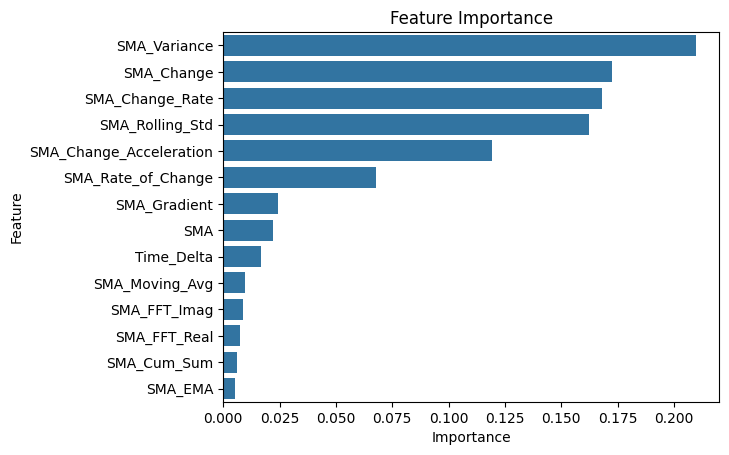

In [97]:
# Plot feature importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

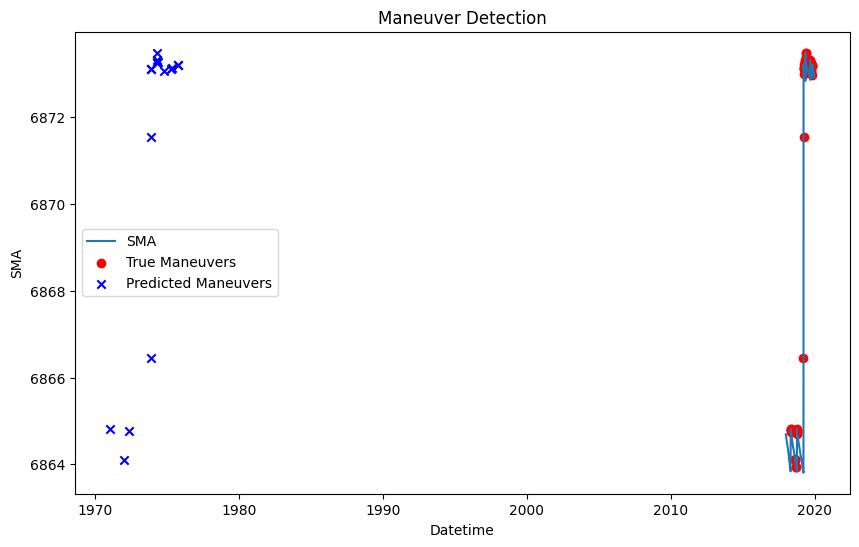

In [98]:
# Visualize predictions (optional)
plt.figure(figsize=(10, 6))
plt.plot(data['Datetime'], data['SMA'], label='SMA')
plt.scatter(data['Datetime'][data['Maneuver_Label'] == 1], data['SMA'][data['Maneuver_Label'] == 1], color='red', label='True Maneuvers')
plt.scatter(X_test.index[y_pred == 1], X_test['SMA'][y_pred == 1], color='blue', marker='x', label='Predicted Maneuvers')
plt.xlabel('Datetime')
plt.ylabel('SMA')
plt.legend()
plt.title('Maneuver Detection')
plt.show()